# Sentiment Analysis and Reducing Costs in the Film Industry

## 1. Import libraries

In [19]:
#Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk # Natural Language Processing
from sklearn.feature_extraction.text import CountVectorizer # Bag of Words
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords  # List of common words usually ignored in text analysis
#from nltk.stem.porter import PorterStemmer  # For stemming using the Porter algorithm
from wordcloud import WordCloud, STOPWORDS  # To create word cloud visualizations from text
from nltk.stem import WordNetLemmatizer  # For lemmatization
from nltk.tokenize import word_tokenize, sent_tokenize  # For word and sentence tokenization
from bs4 import BeautifulSoup  # For HTML and XML parsing (web scraping)
import spacy  # Fast and efficient NLP library
import re, string, unicodedata  # For string manipulation and text normalization
from nltk.tokenize.toktok import ToktokTokenizer  # More efficient tokenizer
from nltk.stem import LancasterStemmer, WordNetLemmatizer  # Alternatives for stemming and lemmatization
from sklearn.linear_model import LogisticRegression, SGDClassifier  # Logistic regression and SGD classifiers for classification
from sklearn.naive_bayes import MultinomialNB  # Classification using Naive Bayes
from sklearn.svm import SVC  # Support Vector Classifier
from textblob import TextBlob  # For text and sentiment analysis
from textblob import Word  # For word processing
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # For model evaluation
import time  # For measuring code execution time

import warnings
warnings.filterwarnings('ignore')  # Ignore warnings

## 2. Dataset

In [20]:
imdb_dataset = pd.read_csv('C:/Users/Nosse/IMDBDataset.csv') #load data
print(imdb_dataset.shape)
imdb_dataset.head(16)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


### 2.1 Dataset info

In [21]:
imdb_dataset.describe() #dataset summary

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [22]:
imdb_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


### 2.2 Sentiment count-info

In [23]:
imdb_dataset['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

## 3. Pre-Processing : Cleaning-Text

### 3.1 Remove HTML tags & Noise from the text

In [24]:
#remove html from text
def remove_html(text):
    
    if not isinstance(text, str):
        text = str(text)
        
    ss = BeautifulSoup(text, "html.parser")
    return ss.get_text()
    
#remove text between square brackets
def remove_btw_square_bb(text):
    return re.sub(r'\[[^]]*\]','',text)

#call all the function to clean text
def remove_noise_txt(text):
    text = remove_html(text)
    text = remove_btw_square_bb(text)
    return text

#apply the function
imdb_dataset['review']= imdb_dataset['review'].apply(remove_noise_txt)


#### Explanation:

1. **Removing HTML from text**: the function *remove_html(text)* uses BeautifulSoup to parse HTML content from the given text and extract only text without the tags. Useful fro cleaning reviews that may contain HTML tags.
   
2. **Removing text bewtween square brackets**: the function *remove_btw_square_bb(text)* utilizes a regex (regular expression), to find and remove (replace) any text that appears between square brackets, this helps to eliminate irrelevant information.
   
3. **Removing Noise from text**: the function  *remove_noise_txt(text)* combines the two previous functions, first remove HTML tags and then eliminates text that is enclosed in square brackets.

### 3.2 Removing special CHR

In [25]:
#Function to remove special chr with regex
def remove_sp_CHR(text, remove_digits=True):
    pattern= r'[^a-zA-z0-9\s]'
    text = re.sub(pattern,'',text)
    return text

#Function call
imdb_dataset['review']= imdb_dataset['review'].apply(remove_sp_CHR)

#### Explanation:

### 3.3 Result of Text Cleaned:

In [26]:
imdb_dataset.head(16)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production The filming tech...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically theres a family where a little boy J...,negative
4,Petter Matteis Love in the Time of Money is a ...,positive
5,Probably my alltime favorite movie a story of ...,positive
6,I sure would like to see a resurrection of a u...,positive
7,This show was an amazing fresh innovative ide...,negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


## 4. Exploratory Data Analysis and General Pre-Processing

### 4.1 Null or Duplicate values Detection (columns - rows)

In [27]:
null_var_column = imdb_dataset.isnull().sum() #null values in dataset
print("Null values - each column: \n",null_var_column)

duplicate_rows = imdb_dataset.duplicated().sum() #duplicate rows in dataset
print("\n Duplicates -  rows: \n",duplicate_rows)

Null values - each column: 
 review       0
sentiment    0
dtype: int64

 Duplicates -  rows: 
 419


#### Explanation

### 4.2 Working Features

#### 4.2.1 Review Length

In [28]:
imdb_dataset['review_len'] = imdb_dataset['review'].apply(lambda x: len(x.split())) #Creates a new column with the length (in number of words) of each review.

imdb_dataset.head(10)

,review,sentiment,review_len
0,One of the other reviewers has mentioned that ...,positive,301
1,A wonderful little production The filming tech...,positive,156
2,I thought this was a wonderful way to spend ti...,positive,162
3,Basically theres a family where a little boy J...,negative,129
4,Petter Matteis Love in the Time of Money is a ...,positive,222
5,Probably my alltime favorite movie a story of ...,positive,119
6,I sure would like to see a resurrection of a u...,positive,150
7,This show was an amazing fresh innovative ide...,negative,170
8,Encouraged by the positive comments about this...,negative,124
9,If you like original gut wrenching laughter yo...,positive,31


#### 4.2.2 Unique Review Length and Binning length

In [29]:
unique_len = imdb_dataset['review_len'].unique() #Unique column of rev_len
print("Unique Review Lengths:")
print(unique_len)

Unique Review Lengths:
[ 301  156  162 ... 1062  874 1136]


In [30]:
#Defining binning range and labels
bins= [0,100,500,1000,1500,float('inf')]
labels = ['Short','Medium','Large','Extra Large','Extra Extra Large']

#New Column based on binning rules
imdb_dataset['review_len_binned'] = pd.cut(imdb_dataset['review_len'],bins=bins,labels=labels,right=True)

print(imdb_dataset[['review_len', 'review_len_binned']].head(10)) #display binned length

   review_len review_len_binned
0         301            Medium
1         156            Medium
2         162            Medium
3         129            Medium
4         222            Medium
5         119            Medium
6         150            Medium
7         170            Medium
8         124            Medium
9          31             Short


### 4.3 Sentiment Class Distribution

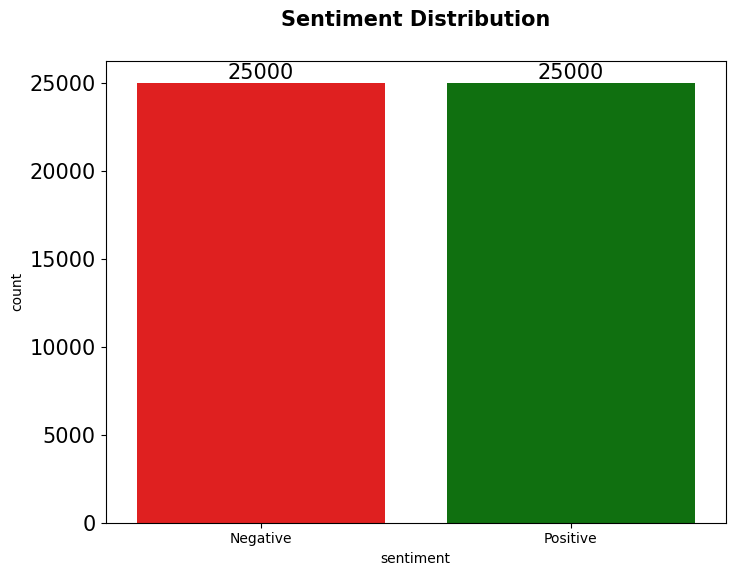

In [34]:
plt.figure(figsize=(8,6)) #plot size

ax= sns.countplot(x='sentiment',data=imdb_dataset, palette=['#FF0000', '#008000']) # define (Axis X)

plt.title('Sentiment Distribution',fontsize=15,weight='bold',ha='center',pad=25) # plot title

#Add counts value above
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',(p.get_x() + p.get_width() /2.,p.get_height()),ha='center', va='bottom', fontsize=15)

ax.set_xticklabels(['Negative','Positive'],ha='center') #Set x-axis labels
ax.tick_params(axis='y', labelsize=15)

#display plot
plt.show() 


#### Note

The Negative and Positive classes are balance in the dataset